# Gaussian discriminant analysis.

The input data is the MNIST dataset, and we simply have to assign it a label accurately using either Linear Discriminant Analysis (LDA) or Quadratic Discriminant Analysis (QDA).

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import random

import numpy as np
from numpy.linalg import inv
from numpy.linalg import det
import scipy.io
import os 
import time
from functools import reduce

In [5]:
# This function corrects the contrast on an image using the L2 norm
def contrastCorrect( image ): 
    
    # Get L2 norm
    l2norm = np.sqrt( (image.T).dot( image ) )
    
    # If all pixels are zero, set to one to avoid infinite
    if l2norm == 0: l2norm = 1
    
    # Return corrected image
    return image/l2norm

# This function estimates mu for a set of images
def estimateMu( imageList ):
    return np.mean( imageList, 0 )

# This function estimates the covariance matrix for a set of images
def estimateCov( imageList ):  
    return np.cov( imageList, rowvar = False )

# Select test and training data
def shuffleData( data, labels ):
    
    # Pair data
    pairedData = list( zip( data, labels ) )
    
    # Shuffle it
    random.shuffle( pairedData )
    
    # Shuffled values
    sData, sLabels = list( zip( *pairedData ) )
    
    return sData, sLabels

# Extract test data
def separateTestData( data, labels, nItems ):
    
    # Shuffle input data
    sData, sLabels = shuffleData( data, labels )
    
    # Training set
    trainingData, trainingLabels = sData[:-nItems], sLabels[:-nItems]
    
    # Test set
    testData, testLabels = sData[-nItems:], sLabels[-nItems:]
    
    return trainingData, trainingLabels, testData, testLabels 

    
# Classify data according to label
def classifyData( data, labels ):
        
    cache = dict()
    for i, image in enumerate( data ):
        label = labels[ i ]
        
        if label in cache: cache[ label ] += [ image ]
        else: cache[ label ] = [ image ]
    
    # Get into array
    for key in cache:
        cache[ key ] = np.array( cache[ key ] )
        
    return cache

# Obtain mu and the covariance matrix for each label
def muAndCovClassified( classifiedData ):
    
    # Initialize dictionaries
    mu, cov = dict(), dict()
    
    # Run through each case and obtain mu and covariance
    for label in classifiedData.keys():
        mu[ label ]  = estimateMu( classifiedData[ label ] )
        cov[ label ] = estimateCov( classifiedData[ label ] )
        
    return mu, cov

# Get Moore-Penrose Pseudoinverse
def pseudoInverse( A ):
    
    # SVD Decomposition
    U, S, Vh = np.linalg.svd( A )
    
    # Pseudo-inverse of diagonal
    Spinv = np.diag( [ 1/x if x != 0 else 0 for x in S ] )
    
    # Pseudo-inverse matrix
    pinvA = Vh.T.dot( Spinv ).dot( U.T )
    
    return pinvA

#### Functions for LDA ####

# Linear discrimination function
def linearDiscrim( muC, pinvCov, x ):    
    return muC.T.dot( pinvCov ).dot( x ) - 1/2 * muC.T.dot( pinvCov ).dot( muC )

# Find best matching label
def LADTest( image, mu, pinvCov ):
    
    # Get results
    results = ( ( label, linearDiscrim( muC, pinvCov, image ) ) for label, muC in mu.items() )
    
    # Return label with max value
    return max( results, key = lambda x: x[1] )[0]


## Functions for QDA ##

# Quadratic discrimination function
def quadDiscrim( muC, cov, detCov, x ):       
    return -( x - muC ).T.dot( np.linalg.lstsq( cov, x )[0] ) - 1/2 * detCov

# Find best matching label
def QADTest( mu, cov, detCov, image ):
    
    # Get results
    results = ( ( label, quadDiscrim( mu[ label ], cov[ label ], detCov[ label ], image ) ) for label in mu.keys() )

    # Return label with max value
    return max( results, key = lambda x: x[1] )[0]


In [12]:
# Part a)

# Load data
MNIST = scipy.io.loadmat('Data and other resources/mnist-data/mnist_data.mat')

# Change format of labels to integers instead of arrays
cleanLabels =  [ x[0] for x in MNIST['training_labels'] ]

# Correct contrast in images
contrastCorrData = np.array( list( map( contrastCorrect, MNIST[ 'training_data' ] ) ) )

# Shuffle data and separate among training and test data
trainingData, trainingLabels, testData, testLabels = separateTestData( contrastCorrData, cleanLabels, 10000 )

# Group data for each label
groupedData = classifyData( trainingData, trainingLabels )

# Obtain mu and sigma for each category
mu, cov = muAndCovClassified( groupedData )
    

'\nWhat we observe here is that diagonal elements are slightly stronger than non-diagonal elements, yet\nthose cannot be ignored, since from this result it is clear that there are strong correlations between\ndifferent pixels. There are many zeroes in the diagonal, meaning that the problem is over parametrized,\nso we can reduce the number of features by either compressing the image or creating a more sophisticated\nfeature vector that operate over multiple pixels\n'

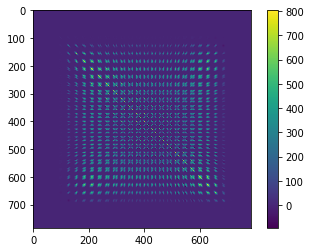

In [7]:
# Part b)
# Visualize the covariance matrix for a particular digit *In this case I chose "0"

plt.imshow( cov[0] )
plt.colorbar()

'''
What we observe here is that diagonal elements are slightly stronger than non-diagonal elements, yet
those cannot be ignored, since from this result it is clear that there are strong correlations between
different pixels. There are many zeroes in the diagonal, meaning that the problem is over parametrized,
so we can reduce the number of features by either compressing the image or creating a more sophisticated
feature vector that operate over multiple pixels
'''



Number of training points:  100 
Accuracy:  8.7 %


Number of training points:  200 
Accuracy:  8.61 %


Number of training points:  500 
Accuracy:  9.13 %


Number of training points:  1000 
Accuracy:  58.47 %


Number of training points:  2000 
Accuracy:  69.59 %


Number of training points:  5000 
Accuracy:  75.67 %


Number of training points:  10000 
Accuracy:  78.21000000000001 %


Number of training points:  30000 
Accuracy:  81.38 %


Number of training points:  50000 
Accuracy:  82.41000000000001 %




Text(0, 0.5, 'Accuracy (%)')

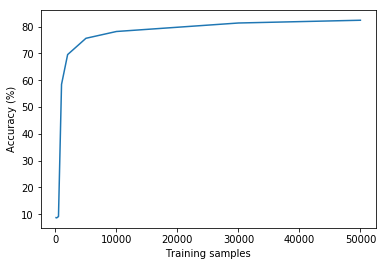

In [8]:
# Part c)
# 1) Use Linear discriminant analysis, LDA on MNIST dataset.

###### Data Training #####
nitems = ( 100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000 )
accuracy = np.zeros( len( nitems ) )

for i, n in enumerate( nitems ):
    
    # Group data for each label
    groupedData = classifyData( trainingData[:n], trainingLabels[:n] )

    # Obtain mu and sigma for each category
    mu, cov = muAndCovClassified( groupedData )
        
    # Obtain an average covariant over all classes
    mnCov = sum( cov.values() )/len( cov )

    # Compute pseudo inverse of covariance
    pinvCov = pseudoInverse( mnCov )

    # Predicted Labels
    predLabels = [ LADTest( image, mu, pinvCov ) for image in testData ]

    # Calculate accuracy using 0-1 loss function
    accuracy[ i ] = sum( bool( predLabel == label ) for predLabel, label in zip( predLabels, testLabels ) )/len( testLabels ) * 100
        
    print( 'Number of training points: ', n, '\nAccuracy: ', accuracy[ i ], '%\n\n' )
    
## Add figure
plt.plot( nitems, accuracy )
plt.xlabel('Training samples')
plt.ylabel('Accuracy (%)')

In [ ]:
# Part c)
# 2) Use Quadratic discriminant analysis, QDA on MNIST dataset.

###### Data Training #####
trainingTime, inferenceTime = 0, 0
nitems = ( 100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000 )
accuracy = np.zeros( len( nitems ) )

for i, n in enumerate( nitems ):
    
    # Group data for each label
    time0 = time.time()
    groupedData = classifyData( trainingData[:n], trainingLabels[:n] )

    # Obtain mu and sigma for each category
    mu, cov = muAndCovClassified( groupedData )
        
    # Compute pseudo inverse of covariance
    pinvCov = { label:pseudoInverse( value ) for label, value in cov.items() }
        
    # Compute determinants
    detCov = { label:np.linalg.det( value ) for label, value in cov.items() }
    time1 = time.time()
    
    # Predicted Labels
    predLabels = [ QADTest( mu, cov, detCov, image ) for image in testData ]
    time2 = time.time()
    
    # Calculate accuracy using 0-1 loss function
    accuracy[ i ] = sum( bool( predLabel == label ) for predLabel, label in zip( predLabels, testLabels ) )/len( predLabels ) * 100
            
    # Collect time data
    trainingTime  += time1 - time0
    inferenceTime += time2 - time1
    
    # Print percentage completed
    print( 'Completed ', i, ' out of', len(nitems), 'iterations' )

## Add figure
plt.plot( nitems, accuracy )
plt.xlabel('Training samples')
plt.ylabel('Accuracy (%)')

# Performance analysis
print( 'Training time:', trainingTime, 's' )
print( 'Inference time:', inferenceTime, 's' )


Text(0, 0.5, 'Accuracy (%)')

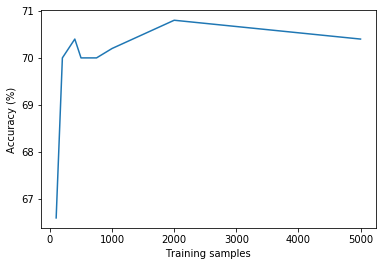

In [17]:
# Load Spam Data

# Load data
Spam = scipy.io.loadmat('Data and other resources/spam-data/spam_data.mat')

# Change format of labels to integers instead of arrays
cleanLabels =  [ x[0] for x in Spam['training_labels'] ]

# Correct contrast in images
contrastCorrData = np.array( list( map( contrastCorrect, Spam[ 'training_data' ] ) ) )

# Shuffle data and separate among training and test data
trainingData, trainingLabels, testData, testLabels = separateTestData( contrastCorrData, cleanLabels, 500 )

# Group data for each label
groupedData = classifyData( trainingData, trainingLabels )

# Obtain mu and sigma for each category
mu, cov = muAndCovClassified( groupedData )

# 1) Use Linear discriminant analysis, LDA on MNIST dataset.

###### Data Training #####
nitems = ( 100, 200, 300, 400, 500, 750, 1000, 2000, 5000 )
accuracy = np.zeros( len( nitems ) )

for i, n in enumerate( nitems ):
    
    # Group data for each label
    groupedData = classifyData( trainingData[:n], trainingLabels[:n] )
        
    # Obtain mu and sigma for each category
    mu, cov = muAndCovClassified( groupedData )
        
    # Obtain an average covariant over all classes
    mnCov = sum( cov.values() )/len( cov )

    # Compute pseudo inverse of covariance
    pinvCov = pseudoInverse( mnCov )

    # Predicted Labels
    predLabels = [ LADTest( image, mu, pinvCov ) for image in testData ]

    # Calculate accuracy using 0-1 loss function
    accuracy[ i ] = sum( bool( predLabel == label ) for predLabel, label in zip( predLabels, testLabels ) )/len( testLabels ) * 100
            
## Add figure
plt.plot( nitems, accuracy )
plt.xlabel('Training samples')
plt.ylabel('Accuracy (%)')